# Main Figure 2: Primary vs secondary infections

This notebook creates the second figure in our publication. Where we explore secondary infections related to the UEFA2020 championship.


In [1]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import pymc3 as pm
import colorsys
sys.path.append("../")
sys.path.append("../covid19_inference")


# Matplotlib config
from header_plotting import *

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from covid19_inference.plot import _format_date_xticks

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
""" General configs
"""
fig_path = "./figures"
country = "England"
xlim_ts = [datetime.datetime(2021,5,30),datetime.datetime(2021,7,23)] # Plotting range
tune = 1000
draws = 1500 
max_treedepth = 12
offset = 0 #offset of soccer games, mainly for sanity checks
width_prior_delay = 0.1

# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}

## Normal trace (with UEFA2020 effect)

In [4]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
fstr=(f"/data.nst/jdehning/covid_uefa_traces11/UEFA"+
    f"-beta=False"+
    f"-country={country}"+
    f"-offset_data=0"+
    f"-draw_delay=True"+
    f"-weighted_alpha_prior=0"+
    f"-prior_delay=-1"+
    f"-width_delay_prior=0.1"+
    f"-sigma_incubation=-1.0"+
    f"-median_width_delay=1.0"+
    f"-interval_cps=10.0"+
    f"-f_fem=0.2"+
    f"-len=normal"+
    f"-tune={tune}"+
    f"-draws={draws}"+
    f"-max_treedepth={max_treedepth}.pickled")
model, trace = load(fstr)
dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])

INFO     [/home/smohr/anaconda3/envs/uefa/lib/python3.9/site-packages/theano/link/c/lazylinker_c.py] Compiling new CVM
INFO     [/home/smohr/anaconda3/envs/uefa/lib/python3.9/site-packages/theano/link/c/lazylinker_c.py] New version 0.211


## Without UEFA2020 effect (primary and secondary)

In [9]:
from utils import getPrimary,getNoSoccer

test
test


In [16]:
trace_without_soccer = getNoSoccer(trace,model)

/home/smohr/anaconda3/envs/uefa/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


## With primary UEFA2020 infections
This requires to define a model to calculate the effect only the primary soccer related infections would have had on the measured cases.

In [26]:
trace_primary_soccer = getPrimary(trace, trace_without_soccer, model,dl)

INFO     [covid19_soccer.utils] pr_sigma_lambda was set to default value 0.2
INFO     [covid19_soccer.utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_soccer.delay_by_weekday] Delaying cases by weekday
INFO     [covid19_inference.model.week_modulation] Week modulation
/home/smohr/anaconda3/envs/uefa/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


## Plotting

In [89]:
from covid19_soccer.plot.rcParams import rcParams
from covid19_soccer.plot.utils import lighten_color
from matplotlib.patches import Patch, Rectangle
from covid19_soccer.plot.other import HandlerRect, MulticolorPatchHandler,MulticolorPatch
from matplotlib.colors import to_hex
import matplotlib.ticker as ticker

from covid19_soccer.plot import timeseries

def plot_corr(ax,GamesXCountry,models):
    x = np.arange(0,np.max(GamesXCountry)+1,0.1)
    # Get y values
    y = []
    for model in models:
        y.append(model.predict(x.reshape(-1,1)))
    y = np.array(y)

    # Compute mean and ci
    mean_mod = y.mean(axis=0)
    p025_mod = np.percentile(y, 2.5,axis=0)
    p975_mod = np.percentile(y,97.5,axis=0)

    # Plot error bars
    lines = ax.vlines(
        x=GamesXCountry,
        ymin=p025,
        ymax=p975,
        lw=2,
        zorder=9,
        color="#060434",
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=GamesXCountry,
        y=mean,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )

    # Plot model fit
    ax.plot(x,mean_mod,color="#009988",lw=1)
    ax.fill_between(x,p025_mod,p975_mod,color="#009988",alpha=0.2)


def plot_legend(ax,loc="upper left"):
    """ Plot the legend onto an axis
    Parameters
    ----------
    ax: mpl axis
    loc: strin
        Location of the legend
    """
    # Legend
    handles = []
    labels = []
    handles.append(ax.get_legend_handles_labels()[0][0])
    labels.append("Model:")


    handles.append(MulticolorPatch(colors_mf[0:2]))
    labels.append("  without soccer effects")

    handles.append(MulticolorPatch(colors_mf[2:4]))
    labels.append("  primary soccer infections")

    handles.append(MulticolorPatch(colors_mf[4:6]))
    labels.append("  subsequent infections")

    handles.append(Patch([0], [0], color="#433f40", lw=0))
    labels.append("Male")

    handles.append(Patch([0], [0], color="#b2acab", lw=0))
    labels.append("Female")

    handles.append(Rectangle([0,0],width=1, height=2.2, lw=1, edgecolor=rcParams.color_championship_range,hatch="////",facecolor = 'none'))
    labels.append("Time window of\nthe championship") 

    ax.legend(
        handles,
        labels,
        handler_map={MulticolorPatch: MulticolorPatchHandler(), Rectangle: HandlerRect(),},
        loc=loc,
    )
    return ax

    
# Data

shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
x = pd.date_range(model.sim_begin, model.sim_end)
y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0)
y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y0
y2 = trace.posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y1 - y0

# Stack and convert to incidence
y = [
    y0[:,0],y0[:,1],
    y1[:,0],y1[:,1],
    y2[:,0],y2[:,1]
]

# Colors
colors_base = ["#fe904c","#92b0ff","#e667a5"]
l = 0.9
d = 1.1

colors_mf = []
for i,col in enumerate(colors_base):
    colors_mf.append(to_hex(lighten_color(col,d)))
    colors_mf.append(to_hex(lighten_color(col,l)))
colors_mf = np.array(colors_mf)


In [90]:
np.array(y).shape

(6, 108)

In [91]:
# Load data for 2nd plot see effect_vs_nGames.ipynb
import pickle
nGames, modelsLin,[mean,p025,p975] = pickle.load(open( fig_path+"/effect_vs_nGames.pkl","rb"))

/tmp/ipykernel_106762/3136695997.py:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles.append(Patch([0], [0], color="#433f40", lw=0))
/tmp/ipykernel_106762/3136695997.py:75: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles.append(Patch([0], [0], color="#b2acab", lw=0))


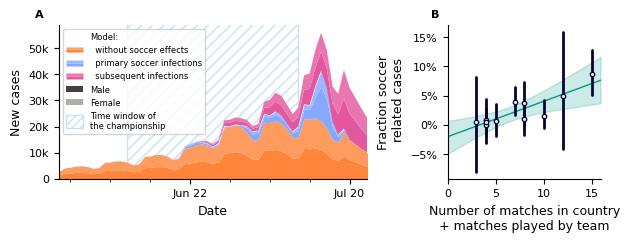

In [92]:
import string
from covid19_soccer.plot.timeseries import _uefa_range
from covid19_soccer.plot.utils import k_formatter
# Plot data
fig, axes = plt.subplots(1,2,figsize=(7,2.0),gridspec_kw={"width_ratios":[2,1], "wspace":0.35})

ax = axes[0]
ax.plot([], [], alpha=0, label="a")

"""Panel A
"""
# Show time of uefa championship
_uefa_range(ax)

timeseries.stacked_filled(x,y,ax=ax, colors=colors_mf, label="b")

# Markup
ax.set_xlim(*xlim_ts)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(k_formatter))
ax.set_ylim(0,59000)
ax.set_xlabel("Date")
ax.set_ylabel("New cases")
plot_legend(ax)


"""Panel B
"""
plot_corr(axes[1],nGames,modelsLin)
axes[1].set_ylabel("Fraction soccer\n related cases")
axes[1].set_xlabel("Number of matches in country\n+ matches played by team")
axes[1].yaxis.set_major_formatter(ticker.PercentFormatter(1.0,0))
axes[1].set_xlim(0,16)


#Add axes annotations
alphabet_string = list(string.ascii_uppercase)
for i, ax in enumerate(axes):
    letter = alphabet_string[i]
    ax.text(-0.05, 1.1, letter, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='right')

plt.show()

fig.savefig(f"{fig_path}/primary_vs_infections_chains_{country}_a.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/primary_vs_infections_chains_{country}_a.png", **save_kwargs)
plt.close(fig=fig)

/tmp/ipykernel_106762/3136695997.py:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles.append(Patch([0], [0], color="#433f40", lw=0))
/tmp/ipykernel_106762/3136695997.py:75: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles.append(Patch([0], [0], color="#b2acab", lw=0))


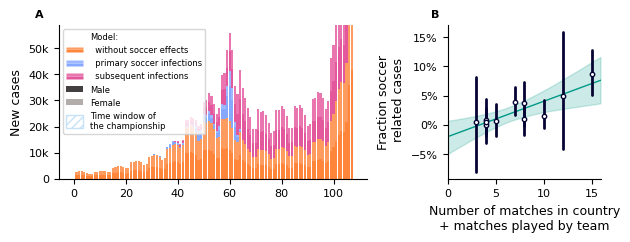

In [113]:
# Plot data
fig, axes = plt.subplots(1,2,figsize=(7,2.0),gridspec_kw={"width_ratios":[2,1], "wspace":0.35})

ax = axes[0]
ax.plot([], [], alpha=0, label="a")

timeseries.stacked_bars(x,y,ax=ax, colors=colors_mf,label="b",width=0.8,date_format=False)
timeseries._timeseries(x,np.sum(y,axis=0),ax=ax,what="model",color="#433f40",label="c",ls="--",lw=1)



# Show time of uefa championship
_uefa_range(ax)

# Markup
ax.set_xlim(*xlim_ts)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(k_formatter))
ax.set_ylim(0,59000)

ax.set_ylabel("New cases")

plot_legend(ax)
# Panel B
plot_corr(axes[1],nGames,modelsLin)
axes[1].set_ylabel("Fraction soccer\n related cases")
axes[1].set_xlabel("Number of matches in country\n+ matches played by team")
axes[1].yaxis.set_major_formatter(ticker.PercentFormatter(1.0,0))
axes[1].set_xlim(0,16)


#Add axes annotations
alphabet_string = list(string.ascii_uppercase)
for i, ax in enumerate(axes):
    letter = alphabet_string[i]
    ax.text(-0.05, 1.1, letter, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='right')

plt.show()

fig.savefig(f"{fig_path}/primary_vs_infections_chains_{country}_b.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/primary_vs_infections_chains_{country}_b.png", **save_kwargs)
plt.close(fig=fig)